In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Set signal parameters
num_channels = 5   # Number of signal channels
num_samples = 600  # Number of time samples
sampling_rate = 200  # Sampling rate
low_freq = 0  # Lower limit of the desired frequency range
high_freq = 80  # Upper limit of the desired frequency range

# Construct a multi-channel signal
t = np.linspace(start=0, stop=(num_samples-1)/sampling_rate, num=num_samples)
signals = 3*np.sin(2*np.pi*3*t) + 2*np.sin(2*np.pi*15*t) + np.sin(2*np.pi*27*t)  # The signal contains three components, amplitudes are 3, 2, 1, frequencies are 3, 15, 27 respectively
noise_level = 0.5
noise = np.random.normal(0, noise_level, signals.shape)
signals = signals + noise  # Add noise
signals = np.tile(signals, (num_channels, 1))  # Duplicate into multi-channel signal
print('signals shape:', signals.shape)  # (channels, time_samples)

# Convert signals to tensor format
tensor_signals = torch.tensor(signals, dtype=torch.float32)

signals shape: (5, 600)


`torch.fft.fft` and `torch.fft.rfft` are both tools to perform fast Fourier transform (FFT) in PyTorch, here are the differences between them:
- `torch.fft.fft`:
    - Processes either real or complex inputs and outputs complex results, which include both positive and negative frequency components.
    - When the input is real, the output is symmetric, thus containing redundant information.
    - When the input is complex, the output is asymmetric and fully represents the complex amplitude and phase information for all frequencies.
- `torch.fft.rfft`:
    - Specifically designed for performing Fourier transforms on real-number sequences; it only handles real inputs.
    - Outputs the complex results of non-negative frequencies, thereby reducing computational complexity.

fft_signals shape: torch.Size([5, 600])
rfft_signals shape: torch.Size([5, 301])
freqs length: 600
freqs list:
 tensor([   0.0000,    0.3333,    0.6667,    1.0000,    1.3333,    1.6667,
           2.0000,    2.3333,    2.6667,    3.0000,    3.3333,    3.6667,
           4.0000,    4.3333,    4.6667,    5.0000,    5.3333,    5.6667,
           6.0000,    6.3333,    6.6667,    7.0000,    7.3333,    7.6667,
           8.0000,    8.3333,    8.6667,    9.0000,    9.3333,    9.6667,
          10.0000,   10.3333,   10.6667,   11.0000,   11.3333,   11.6667,
          12.0000,   12.3333,   12.6667,   13.0000,   13.3333,   13.6667,
          14.0000,   14.3333,   14.6667,   15.0000,   15.3333,   15.6667,
          16.0000,   16.3333,   16.6667,   17.0000,   17.3333,   17.6667,
          18.0000,   18.3333,   18.6667,   19.0000,   19.3333,   19.6667,
          20.0000,   20.3333,   20.6667,   21.0000,   21.3333,   21.6667,
          22.0000,   22.3333,   22.6667,   23.0000,   23.3333,   23.6667,


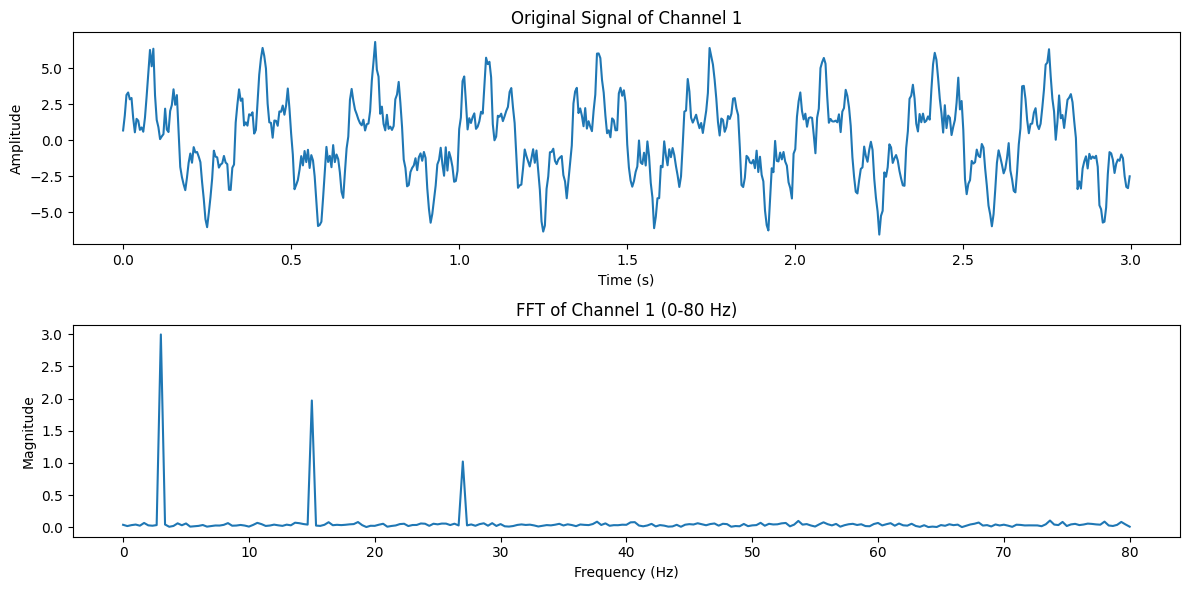

In [2]:
# Using PyTorch for FFT
fft_signals = torch.fft.fft(tensor_signals, dim=1)
rfft_signals = torch.fft.rfft(tensor_signals, dim=1)
print('fft_signals shape:', fft_signals.shape)
print('rfft_signals shape:', rfft_signals.shape)

# Retrieve frequency lists
freqs = torch.fft.fftfreq(num_samples, 1/sampling_rate)  # Get frequency list
rfreqs = torch.fft.rfftfreq(num_samples, 1/sampling_rate)  # Get non-negative frequency list
print('freqs length:', len(freqs))
print('freqs list:\n', freqs)
print('rfreqs length:', len(rfreqs))
print('rfreqs list:\n', rfreqs)

# In the following steps, we only use list freqs for visualization
# Select the desired frequency range
mask = (freqs >= low_freq) & (freqs <= high_freq)  # Create a mask for the frequency range

# Select a signal from one channel for visualization
channel_idx = 0
selected_channel_signal = signals[channel_idx]  # Time-domain signal
selected_channel_fft = fft_signals[channel_idx][mask]  # FFT signal within the selected frequency range

# Plot the original signal
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, selected_channel_signal)
plt.title(f'Original Signal of Channel {channel_idx+1}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Plot the frequency domain signal
plt.subplot(2, 1, 2)
plt.plot(freqs[mask], 2.0/num_samples * torch.abs(selected_channel_fft))  # The 2.0/num_samples factor is used for normalization
plt.title(f'FFT of Channel {channel_idx+1} ({low_freq}-{high_freq} Hz)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.tight_layout()
plt.show()


In [5]:
# Custom FFT Layer
class FFTLayer(nn.Module):
    """
    Input: (batch, channel, time)
    Output: (batch, channel, freq_len), (freq_len,)
    """
    def __init__(self, sampling_rate, low_freq=None, high_freq=None):
        super().__init__()
        self.low_freq = low_freq
        self.high_freq = high_freq
        self.sampling_rate = sampling_rate

    def forward(self, x):
        num_samples = x.shape[2]
        x = torch.fft.fft(x, dim=2)
        factor = 2.0  # Normalization factor
        freqs = torch.fft.fftfreq(num_samples, 1 / self.sampling_rate)
        if (self.low_freq is None) and (self.high_freq is None):
            fft = torch.abs(x)  # If no desired frequency range
        else:
            # Apply frequency masks based on desired frequency range
            if (self.low_freq is None) and (self.high_freq is not None):
                mask = freqs <= self.high_freq
            elif (self.low_freq is not None) and (self.high_freq is None):
                mask = freqs >= self.low_freq
            else:
                mask = (freqs >= self.low_freq) & (freqs <= self.high_freq)
            fft = torch.abs(x[..., mask])  # Apply mask to FFT results
            freqs = freqs[mask]  # Update frequencies to include only the selected range
        if self.low_freq is None or self.low_freq < 0:  # If negative frequencies are included, adjust the normalization factor to 1
            factor = 1.0
        
        return (factor / num_samples) * fft, freqs  # Return normalized FFT results and frequencies

torch.Size([1, 5, 241])
torch.Size([241])


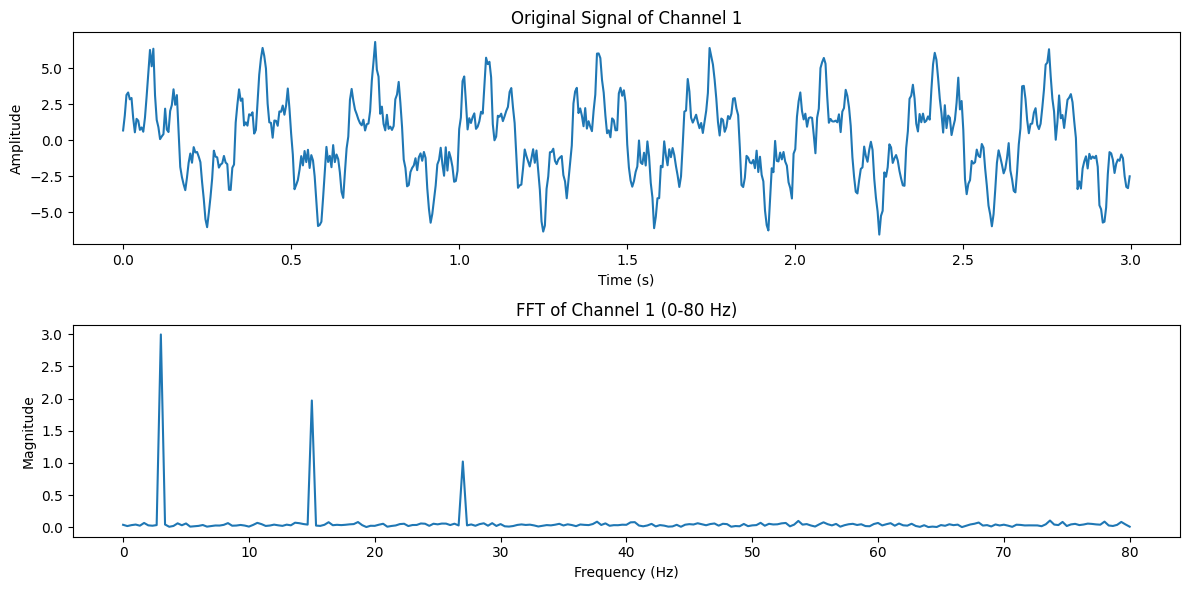

In [6]:
sig = tensor_signals.unsqueeze(0)  # Convert (channels, time_samples) to (1, channels, time_samples), where 1 represents batch size
fft, freq = FFTLayer(sampling_rate=sampling_rate, low_freq=low_freq, high_freq=high_freq)(sig)  # Apply the custom FFT layer
print(fft.shape)  # Print the shape of the FFT output
print(freq.shape)  # Print the shape of the frequency data

# Plot the original signal
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, sig[0, channel_idx, :])
plt.title(f'Original Signal of Channel {channel_idx+1}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Plot the frequency-domain signal
plt.subplot(2, 1, 2)
plt.plot(freq, fft[0, channel_idx, :])
plt.title(f'FFT of Channel {channel_idx+1} ({low_freq}-{high_freq} Hz)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.tight_layout()
plt.show()


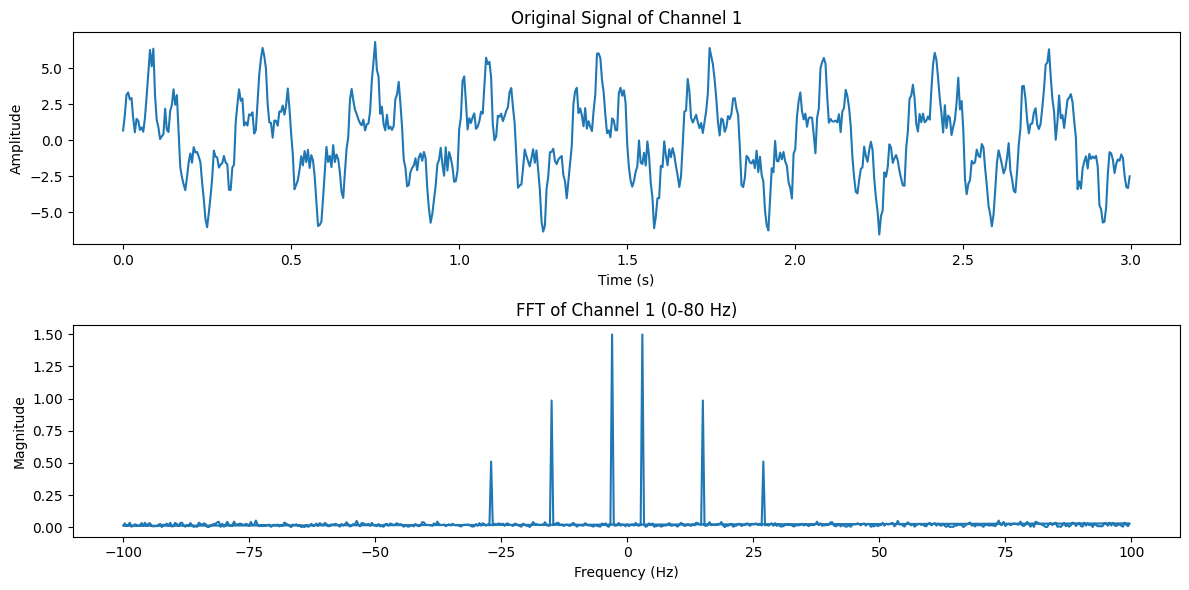

In [7]:
# If there is no desired frequency range
fft, freq = FFTLayer(sampling_rate=sampling_rate)(sig)

# Plot the original signal
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, sig[0, channel_idx, :])
plt.title(f'Original Signal of Channel {channel_idx+1}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Plot the frequency-domain signal
plt.subplot(2, 1, 2)
plt.plot(freq, fft[0, channel_idx, :])
plt.title(f'FFT of Channel {channel_idx+1} ({low_freq}-{high_freq} Hz)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.tight_layout()
plt.show()